In [127]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [128]:
# read grayscale
# original = cv2.imread("pic.jpg", cv2.IMREAD_GRAYSCALE)
original = cv2.imread("mirror.jpg", cv2.IMREAD_GRAYSCALE)

In [129]:
# rescale and blur
img = cv2.resize(original, (500, 500), interpolation=cv2.INTER_AREA)
# img = cv2.GaussianBlur(img, (5, 5), 0)

In [130]:
def erode(img, size):
    element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * size + 1, 2 * size + 1), (size, size)
    )

    return cv2.erode(img, element)


def dilate(img, size):
    element = cv2.getStructuringElement(
        cv2.MORPH_RECT, (2 * size + 1, 2 * size + 1), (size, size)
    )

    return cv2.dilate(img, element)


def opening(x, size=3):
    return dilate(erode(x, size), size)


def closing(x, size=3):
    return erode(dilate(x, size), size)


def sobelY(img):
    sobelx64f = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)


def sobelX(img):
    sobelx64f = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)

In [131]:
img = opening(img, 3)
img = closing(img, 5)
# img = cv2.medianBlur(img, 5)
sobY = sobelY(img)
sobX = sobelX(img)
# sum = cv2.addWeighted(sobX, 0.5, sobY, 0.5, 0)

In [132]:
# Convert to binary
_, sobXBinary = cv2.threshold(sobX, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, sobYBinary = cv2.threshold(sobY, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#  Standard Hough Line Transform
linesHorizontal = cv2.HoughLines(sobXBinary, 1, np.pi / 180, 150, None, 0, 0)
linesVertical = cv2.HoughLines(sobYBinary, 1, np.pi / 180, 150, None, 0, 0)

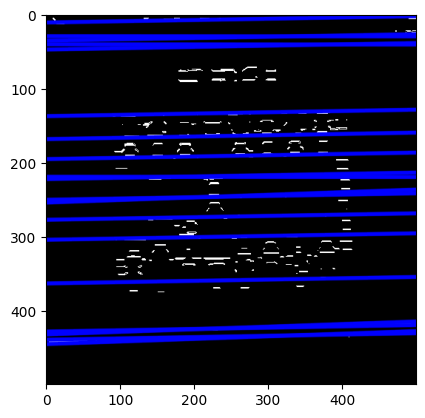

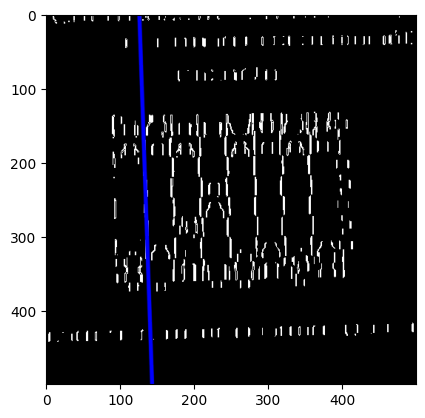

In [133]:
# Color for showing lines
cdstX = cv2.cvtColor(sobXBinary, cv2.COLOR_GRAY2BGR)
cdstY = cv2.cvtColor(sobYBinary, cv2.COLOR_GRAY2BGR)

if linesHorizontal is not None:
    for i in range(0, len(linesHorizontal)):
        rho = linesHorizontal[i][0][0]
        theta = linesHorizontal[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        cv2.line(cdstX, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

if linesVertical is not None:
    for i in range(0, len(linesVertical)):
        rho = linesVertical[i][0][0]
        theta = linesVertical[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))

        cv2.line(cdstY, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
# Show results
plt.figure()
plt.imshow(cdstX)
plt.figure()
plt.imshow(cdstY)

Find the average rotation

In [134]:
angle_threshold = 0.1
sum = 0
count = 0
for line in linesHorizontal:
    angle = line[0][1]
    angle -= math.pi/2
    # filter angles within threshold
    if angle > angle_threshold/2 or angle <  - angle_threshold/2:
        continue
    sum += angle
    count += 1

for line in linesVertical:
    angle = line[0][1]
    if angle > math.pi/2:
        angle -= math.pi
    # filter angles within threshold
    if angle > angle_threshold/2 or angle <  - angle_threshold/2:
        continue
    sum += angle
    count += 1
    
    
avg_rotation = sum/count

Rotate Sobel X and Y

In [135]:
def rotate(img, angle):
    rows,cols = img.shape
    # cols-1 and rows-1 are the coordinate limits.
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

sobX = rotate(sobX,avg_rotation * 180 / math.pi)
sobY = rotate(sobY,avg_rotation * 180 / math.pi)

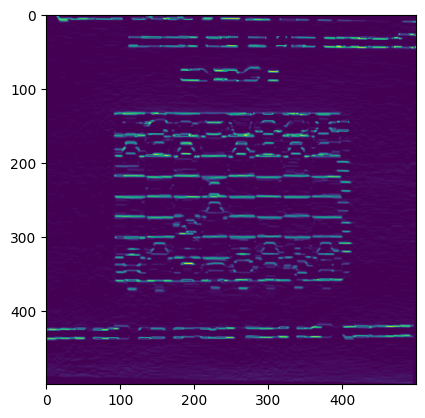

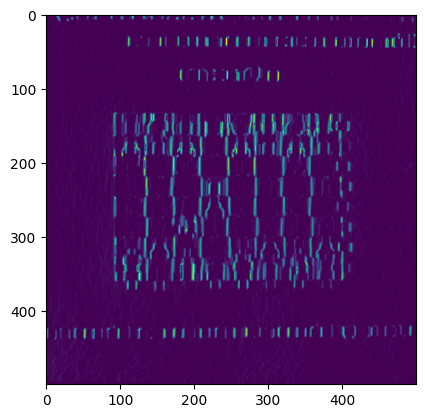

In [136]:
plt.figure()
plt.imshow(sobX)
plt.figure()
plt.imshow(sobY)

In [137]:

# phase = cv2.phase(sobX, sobY)
# # sobX = closing(sobX, 3)
# # multiplied = cv2.multiply(sobX, sobY)

# plt.imshow(phase, cmap="gray")
# # plt.waitforbuttonpress()
# # exit()

# grapharr = phase

# fig, ax = plt.subplots()
# plt.subplots_adjust(bottom=0.25)
# y = 50
# (line,) = plt.plot(grapharr[y])
# plt.grid(True)


# def update(val):
#     y = int(val)
#     line.set_ydata(grapharr[y])
#     fig.canvas.draw_idle()


# from matplotlib.widgets import Slider

# ax_index = plt.axes([0.25, 0.1, 0.65, 0.03])
# slider_index = Slider(ax_index, "Y", 0, len(grapharr) - 1, valinit=y, valstep=1)
# slider_index.on_changed(update)

# plt.show()

In [138]:
# # Split the image into tiles
# w, h = image.shape
# tiles = []

# for x in range(8):
#     for y in range(8):
#         x1 = round(w * (x/8))
#         x2 = round(w * ((x + 1)/8))
#         y1 = round(h * (y/8))
#         y2 = round(h * ((y + 1)/8))
#         tiles.append(image[x1:x2,y1:y2])


# for tile in tiles:
#     cv.imshow('Block', tile)
#     cv.waitKey(0)
# cv.destroyAllWindows()